<a href="https://colab.research.google.com/github/shinbad/can_bus/blob/main/DBC_decoder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DBC file Decoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install cantools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.9 MB/s eta 0:00:00


## 데이터 로드

In [ ]:
import cantools
import pandas as pd

# DBC 파일 로드
dbc_file = '/content/drive/MyDrive/H-SCOPE/hyundai_kia_generic.dbc'
db = cantools.database.load_file(dbc_file)
db

version('')

node('IAP', None)
node('ODS', None)
node('_4WD', None)
node('BCM', None)
node('HUD', None)
node('DATC', None)
node('MDPS', None)
node('AAF_Tester', None)
node('AEMC', None)
node('SMK', None)
node('_4WD', None)
node('EPB', None)
node('CUBIS', None)
node('MTS', None)
node('TMU', None)
node('EVP', None)
node('CGW', None)
node('TPMS', None)
node('LPI', None)
node('DI_BOX', None)
node('SPAS', None)
node('EMS', None)
node('LCA', None)
node('TCU', None)
node('IBOX', None)
node('FATC', None)
node('AFLS', None)
node('FPCM', None)
node('SCC', None)
node('AHLS', None)
node('AVM', None)
node('ABS', None)
node('SNV', None)
node('OPI', None)
node('PGS', None)
node('SAS', None)
node('AAF', None)
node('Dummy', None)
node('LDWS_LKAS', None)
node('LVR', None)
node('ESC', None)
node('PSB', None)
node('CLU', None)
node('ECS', None)
node('ACU', None)
node('REA', None)

message('ODS13', 0x5fc, False, 5, None)
  signal('CR_Ods_ID', 0, 8, 'little_endian', False, None, 1, 0, 0.0, 255.0, 'None', Fa

In [ ]:
# CSV 파일 로드
csv_file = '/content/drive/MyDrive/H-SCOPE/CAN(자동차 네트워크 보안)/0_Preliminary/0_Preliminary/0_Training/split/Pre_train_D_1_0.csv'
df = pd.read_csv(csv_file)
can_data = df.copy()
basetime = can_data['Timestamp'][0]
can_data['Timestamp'] = can_data['Timestamp'] - basetime
can_data.head(10)

,Timestamp,Arbitration_ID,DLC,Data,Class,SubClass
0,0.000000,153,8,20 A1 10 FF 00 FF 50 1F,Normal,Normal
1,0.000258,220,8,13 24 7F 60 05 FF BF 10,Normal,Normal
2,0.000417,507,4,08 00 00 01,Normal,Normal
3,0.001354,356,8,00 00 00 80 16 00 00 00,Normal,Normal
4,0.001587,340,8,FC 03 00 E4 B7 21 FA 3C,Normal,Normal
5,0.001805,366,7,33 B0 0A 33 30 00 01,Normal,Normal
6,0.002045,367,8,00 00 00 00 06 00 8D 0A,Normal,Normal
7,0.002291,368,8,00 00 00 00 00 C0 0A 40,Normal,Normal
8,0.002525,470,8,15 41 01 04 54 50 54 B9,Normal,Normal
9,0.002708,453,5,00 88 8B 00 C1,Normal,Normal


##Decoding & csv file save

In [ ]:
# 디코딩된 결과를 저장할 리스트
decoded_messages = []
# 정의되지 않은 메시지 ID를 저장할 리스트
undefined_message_ids = []

# CSV 파일의 각 행에 대해 CAN 메시지 디코딩
for index, row in can_data.iterrows():
    message_id = int(row['Arbitration_ID'], 16)  # ID를 16진수로 변환
    message_data = bytes.fromhex(row['Data'])  # 데이터를 바이트 배열로 변환
    print(message_data)

    # 메시지의 예상 길이 가져오기
    try:
        message = db.get_message_by_frame_id(message_id)
        expected_length = message.length
    except KeyError:
        # 정의되지 않은 메시지 ID인 경우
        print(f"Message ID {message_id} is not defined in the DBC file.")
        undefined_message_ids.append(message_id)
        continue

    # 데이터 길이 확인 및 조정
    if len(message_data) < expected_length:
        message_data = message_data.ljust(expected_length, b'\x00')  # 패딩 추가
    elif len(message_data) > expected_length:
        message_data = message_data[:expected_length]  # 초과된 데이터 잘라내기

    # 메시지 디코딩
    try:
        decoded_message = db.decode_message(message_id, message_data)
        decoded_message['Timestamp'] = row['Timestamp']  # 타임스탬프 추가
        decoded_message['Arbitration_ID'] = row['Arbitration_ID']  # ID 추가
        decoded_message['SubClass'] = row['SubClass']  # ID 추가
        decoded_messages.append(decoded_message)
    except Exception as e:
        # 기타 오류 처리
        print(f"Error decoding message ID {message_id}: {e}")

# 디코딩된 메시지 출력
decoded_df = pd.DataFrame(decoded_messages)
print(decoded_df)

# 디코딩된 메시지를 CSV 파일로 저장
decoded_df.to_csv('decoded_can_data_AddID.csv', index=False)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Message ID 1145 is not defined in the DBC file.
b'\x04V\xff\xff\x00{\x00B'
b'\x00\x00\x00\x00\x0c\xcf\x00\x00'
b'\tC)0\x00\xe6\xb3y'
b'\x84\xc5~\x8c1:\x12\x10'
b'\x00`\x08\x00.4\x1a\xfc'
b'\x00\x08\x05\xc2'
b'\xc5v\xf1b\x00\x90\x02\x00'
b'\x80 <\x00\x00v\x99\x05'
b'\xec\x7f\x94\x80\x00\x00\x0c\xd9'
b'\xbc\x81\x00o \x00\x0c:'
b'b\x03\xeaJ\x00\x84g~'
b'\xed\xff\x01\x07\xfa\xb8'
b'\x00\x00\x00\x00\x00\x00\x08\xeb'
b'\xa0!`\x81'
b'@\x0c\x00\xb1\x05P\x00\xe2'
b'\xfc\x03\x00\xe4\xd7!\xaa<'
b'\r$\x85\x00\x00\xff?]'
b' \xa1\x10\xff\x00\xff@\x0f'
b'\x00\x00\x00\x80H\x00\x00\x00'
b"B` C'\x0e\x01"
b'\x00\x00\x00\x00\x0c\x00\x95\x1d'
b'\x00\x0fF\x00\x01X B'
b'\x00\x00\x00\x04'
b'\x00\x88\x8d\x00J'
Message ID 1107 is not defined in the DBC file.
b'\x15\x01\x04\x04PPTA'
b'\x03\x04A\x80\xc0\x00\x00\x04'
b'\tB)0\x00\xe6\xb3M'
b'\x84\xc5~\x8c1:\x12\x10'
b'\x00\x08\x07\xf8'
b'\xdd\xc1\xe0\x01\xdf\xc1\xdd\x01'
b"Z\x03\xebI\x00~'~"
b'\xd4\x7f\x9c\x80\x00\x00\r\xb7'
b'\x

In [ ]:
decoded_can = pd.read_csv('/content/decoded_can_data_AddID.csv')
decoded_can.head(10)

<ipython-input-7-537de9b98445>:1: DtypeWarning: Columns (219,571) have mixed types. Specify dtype option on import or set low_memory=False.
  decoded_can = pd.read_csv('/content/decoded_can_data_AddID.csv')


,TCS_REQ,MSR_C_REQ,TCS_PAS,TCS_GSC,CF_Esc_LimoInfo,ABS_DIAG,ABS_DEF,TCS_DEF,TCS_CTL,ABS_ACT,...,C_FrontEXTTailRhOpenSts,C_RearTSIGLhOpenSts,C_RearTSIGRhOpenSts,C_FrontTSIGLhOpenSts,C_FrontTSIGRhOpenSts,C_SBendingLhOpenSts,C_SBendingRhOpenSts,C_LicensePlateLhOpenSts,C_LicensePlateRhOpenSts,HU_Type
0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 디코딩된 csv 파일 중복되는 컬럼명 확인
 - 없음

In [ ]:
columns = decoded_can.columns

columns_counts = {}

for i in columns:
  try:
    columns_counts[i] += 1
  except:
    columns_counts[i] = 1

columns_counts

{'TCS_REQ': 1,
 'MSR_C_REQ': 1,
 'TCS_PAS': 1,
 'TCS_GSC': 1,
 'CF_Esc_LimoInfo': 1,
 'ABS_DIAG': 1,
 'ABS_DEF': 1,
 'TCS_DEF': 1,
 'TCS_CTL': 1,
 'ABS_ACT': 1,
 'EBD_DEF': 1,
 'ESP_PAS': 1,
 'ESP_DEF': 1,
 'ESP_CTL': 1,
 'TCS_MFRN': 1,
 'DBC_CTL': 1,
 'DBC_PAS': 1,
 'DBC_DEF': 1,
 'HAC_CTL': 1,
 'HAC_PAS': 1,
 'HAC_DEF': 1,
 'ESS_STAT': 1,
 'TQI_TCS': 1,
 'TQI_MSR': 1,
 'TQI_SLW_TCS': 1,
 'CF_Esc_BrkCtl': 1,
 'BLA_CTL': 1,
 'AliveCounter_TCS1': 1,
 'CheckSum_TCS1': 1,
 'Timestamp': 1,
 'Arbitration_ID': 1,
 'SubClass': 1,
 'LAT_ACCEL': 1,
 'LAT_ACCEL_STAT': 1,
 'LAT_ACCEL_DIAG': 1,
 'LONG_ACCEL': 1,
 'LONG_ACCEL_STAT': 1,
 'LONG_ACCEL_DIAG': 1,
 'CYL_PRES': 1,
 'CYL_PRES_STAT': 1,
 'CYL_PRESS_DIAG': 1,
 'YAW_RATE': 1,
 'YAW_RATE_STAT': 1,
 'YAW_RATE_DIAG': 1,
 'ESP12_Checksum': 1,
 'ESP12_AliveCounter': 1,
 'ABS_W_LAMP': 1,
 'TCS_OFF_LAMP': 1,
 'TCS_LAMP': 1,
 'DBC_W_LAMP': 1,
 'DBC_F_LAMP': 1,
 'ESC_Off_Step': 1,
 'AVH_CLU': 1,
 'AVH_I_LAMP': 1,
 'EBD_W_LAMP': 1,
 'AVH_ALARM': 1,
 'A

### Undefined_IDs
-정의되지 않은 ID(Can 데이터 중, DBC 데이터에 없는 ID들)

In [ ]:
undefined_message_ids.sort()
UnData = pd.DataFrame(undefined_message_ids)
UnData.value_counts()

0       19184
1107     7839
1145     1678
1069     1677
1384     1657
1227      975
1394      906
1164      905
1183      895
1343      895
1446      892
1339      890
1102      889
1294      888
1225      887
1193      887
1485      869
1470      281
1188      152
2012      139
2004      134
1988      132
1996      129
2000      126
2008      123
Name: count, dtype: int64

In [ ]:
# 정의되지 않은 ID가 can data에서 어떤 데이터였는지 확인
undefined_ids = [format(id, 'x') for id in undefined_message_ids]

# 000과 0이 문자열 형태로 값을 비교할때 동일한 값으로 인식되지 않아서 000을 0으로 대체
can_data['Arbitration_ID'] = can_data['Arbitration_ID'].replace('000', '0')

matching_ids = can_data[can_data['Arbitration_ID'].isin(undefined_ids)]
matching_ids

,Timestamp,Arbitration_ID,DLC,Data,Class,SubClass
9,0.002708,453,5,00 88 8B 00 C1,Normal,Normal
11,0.003125,568,8,00 00 00 85 80 41 00 00,Normal,Normal
58,0.022843,453,5,00 88 8B 00 D1,Normal,Normal
79,0.032686,479,8,4C 00 00 00 00 00 00 00,Normal,Normal
100,0.042328,453,5,00 88 8B 00 A1,Normal,Normal
...,...,...,...,...,...,...
403041,152.304525,568,8,00 00 00 8C 80 00 00 00,Normal,Normal
403088,152.323439,453,5,00 88 8D 00 68,Normal,Normal
403113,152.333532,479,8,4C 00 00 00 00 00 00 00,Normal,Normal
403139,152.343513,453,5,00 88 8D 00 78,Normal,Normal


SubClass
Normal      366785
Flooding     19184
Fuzzing      11354
Replay        5379
Spoofing       494
Name: count, dtype: int64
SubClass
Flooding    19184
Normal      11403
Fuzzing       510
Replay        167
Name: count, dtype: int64


Text(0.5, 0, 'SubClass')

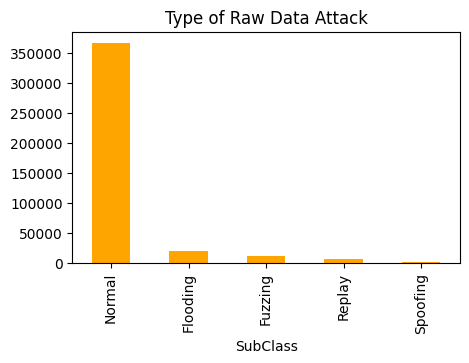

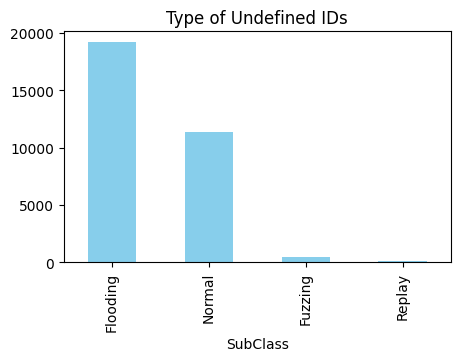

In [ ]:
#정의되지 않은 ID와 원시데이터(raw_data)의 ID별 공격수 비교
import matplotlib.pyplot as plt

attack_count = can_data['SubClass'].value_counts()
print(attack_count)

plt.figure(figsize=(5,3))
attack_count.plot(kind='bar', color = 'orange')
plt.title("Type of Raw Data Attack")
plt.xlabel('SubClass')

Undefined_ids_count = matching_ids['SubClass'].value_counts()
print(Undefined_ids_count)

plt.figure(figsize=(5,3))
Undefined_ids_count.plot(kind='bar', color = 'skyblue')
plt.title("Type of Undefined IDs")
plt.xlabel('SubClass')

### Defined_IDs


SubClass
Normal      345235
Fuzzing       8376
Replay        5062
Spoofing       494
Name: count, dtype: int64


Text(0.5, 0, 'SubClass')

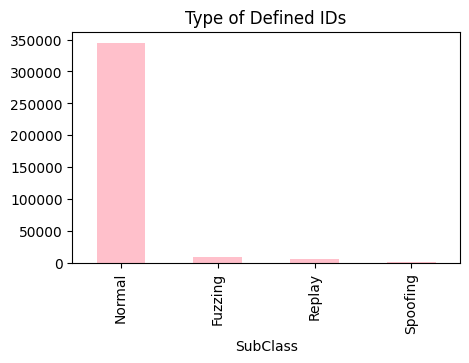

In [ ]:
defined_id_count = decoded_can['SubClass'].value_counts()
print(defined_id_count)

plt.figure(figsize=(5,3))
defined_id_count.plot(kind = 'bar', color = 'pink')
plt.title("Type of Defined IDs")
plt.xlabel('SubClass')

In [ ]:
flooding = can_data[can_data['SubClass'] == 'Flooding']
flooding['Arbitration_ID'].value_counts()

Arbitration_ID
0    19184
Name: count, dtype: int64

Flooding 공격은 모두 DBC 파일의 ID와 일치 하지 않아서 디코딩 되지 않음.  
왜냐하면 ID가 0이기 때문
--> 그렇다면 Flooding 공격의 학습은 어떻게 하는가?
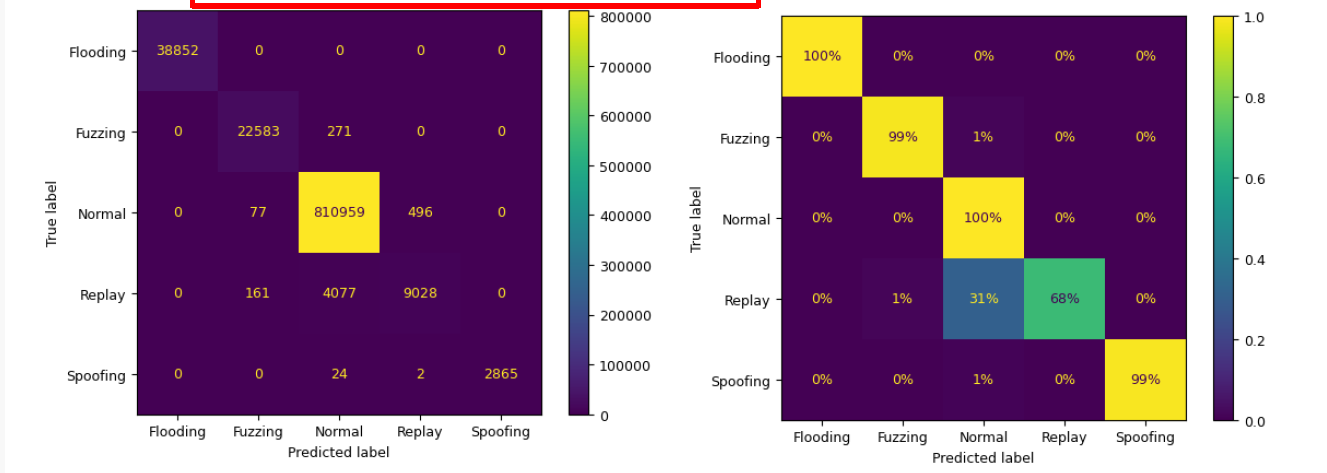
  
원래 Flooding 공격은 정확도가 좋음

### 366데이터분석

In [ ]:
Attack_defined_data = decoded_can[decoded_can['SubClass'].isin(['Fuzzing', 'Replay', 'Spoofing'])]
#Attack_defined_data
Attack_defined_id = Attack_defined_data['Arbitration_ID'].value_counts()
Attack_defined_id

Normal_defined_data = decoded_can[decoded_can['SubClass'] == 'Normal']
#Normal_defined_data
Normal_defined_id = Normal_defined_data['Arbitration_ID'].value_counts()
Normal_defined_id

Arbitration_ID
153    15237
220    15235
356    15233
366    15231
251    15229
2B0    15226
164    15225
340    15225
367    15224
368    15221
130    15221
260    15219
140    15219
329    15214
38D     7614
47F     7614
394     7613
381     7613
387     7612
386     7611
420     7611
391     7611
421     7609
389     7609
4F1     7598
470     7597
58B     3046
490     3046
48A     3046
485     3046
492     3042
436     3040
484     2172
52A     1766
541     1621
507     1520
520     1519
50C     1519
500     1518
495     1518
53E     1518
50A      914
593      761
410      761
483      761
559      760
544      760
553      759
412      759
563      455
4A2      305
4A7      302
043      152
07F      152
5B0      150
57F       76
Name: count, dtype: int64

In [ ]:
Attack_366 = Attack_defined_data[Attack_defined_data['Arbitration_ID'] == '366']
Normal_366 = Normal_defined_data[Normal_defined_data['Arbitration_ID'] == '366']

NaN이 없는 컬럼만 출력

Attack

In [ ]:
# NaN 값이 있는 컬럼들을 제외
non_nan_columns = Attack_366.columns[~Attack_366.isna().any()]

# NaN 값이 없는 컬럼들로 이루어진 DataFrame을 생성
filtered_Attack_366 = Attack_366[non_nan_columns]

print("<NaN 값이 없는 공격 366 data>")
filtered_Attack_366

<NaN 값이 없는 컬럼들>


,Timestamp,Arbitration_ID,SubClass,TQI_1,N,TQI_2,VS,SWI_IGK
152195,67.327182,366,Spoofing,15.625000,16376.50,15.625000,0.0,1.0
152333,67.388098,366,Spoofing,15.625000,16376.50,15.625000,0.0,1.0
152469,67.448848,366,Spoofing,15.625000,16376.50,15.625000,0.0,1.0
152609,67.509709,366,Spoofing,15.625000,16376.50,15.625000,0.0,1.0
152748,67.570669,366,Spoofing,15.625000,16376.50,15.625000,0.0,1.0
...,...,...,...,...,...,...,...,...
333335,141.240358,366,Fuzzing,98.046875,9924.00,16.796875,27.0,1.0
333767,141.389055,366,Fuzzing,21.875000,5869.00,99.609375,238.0,0.0
334018,141.474741,366,Fuzzing,91.406250,731.75,23.437500,227.0,0.0
334085,141.499420,366,Fuzzing,49.609375,2091.75,21.093750,254.0,1.0


Normal

In [ ]:
# NaN 값이 있는 컬럼들을 제외
non_nan_columns = Normal_366.columns[~Normal_366.isna().any()]

# NaN 값이 없는 컬럼들로 이루어진 DataFrame을 생성
filtered_Normal_366 = Normal_366[non_nan_columns]

print("<NaN 값이 없는 정상 366 data>")
filtered_Normal_366

<NaN 값이 없는 공격 366 data>


,Timestamp,Arbitration_ID,SubClass,TQI_1,N,TQI_2,VS,SWI_IGK
5,0.001805,366,Normal,19.921875,684.0,19.921875,0.0,1.0
24,0.010998,366,Normal,20.312500,683.0,20.312500,0.0,1.0
51,0.021936,366,Normal,20.312500,683.0,20.312500,0.0,1.0
68,0.031004,366,Normal,20.312500,683.0,20.312500,0.0,1.0
90,0.041257,366,Normal,20.312500,682.0,20.312500,0.0,1.0
...,...,...,...,...,...,...,...,...
359063,152.322544,366,Normal,11.718750,1655.5,11.718750,15.0,1.0
359085,152.332556,366,Normal,11.718750,1654.5,11.718750,15.0,1.0
359108,152.342679,366,Normal,11.718750,1653.5,11.718750,15.0,1.0
359131,152.352554,366,Normal,11.718750,1650.0,11.718750,15.0,1.0


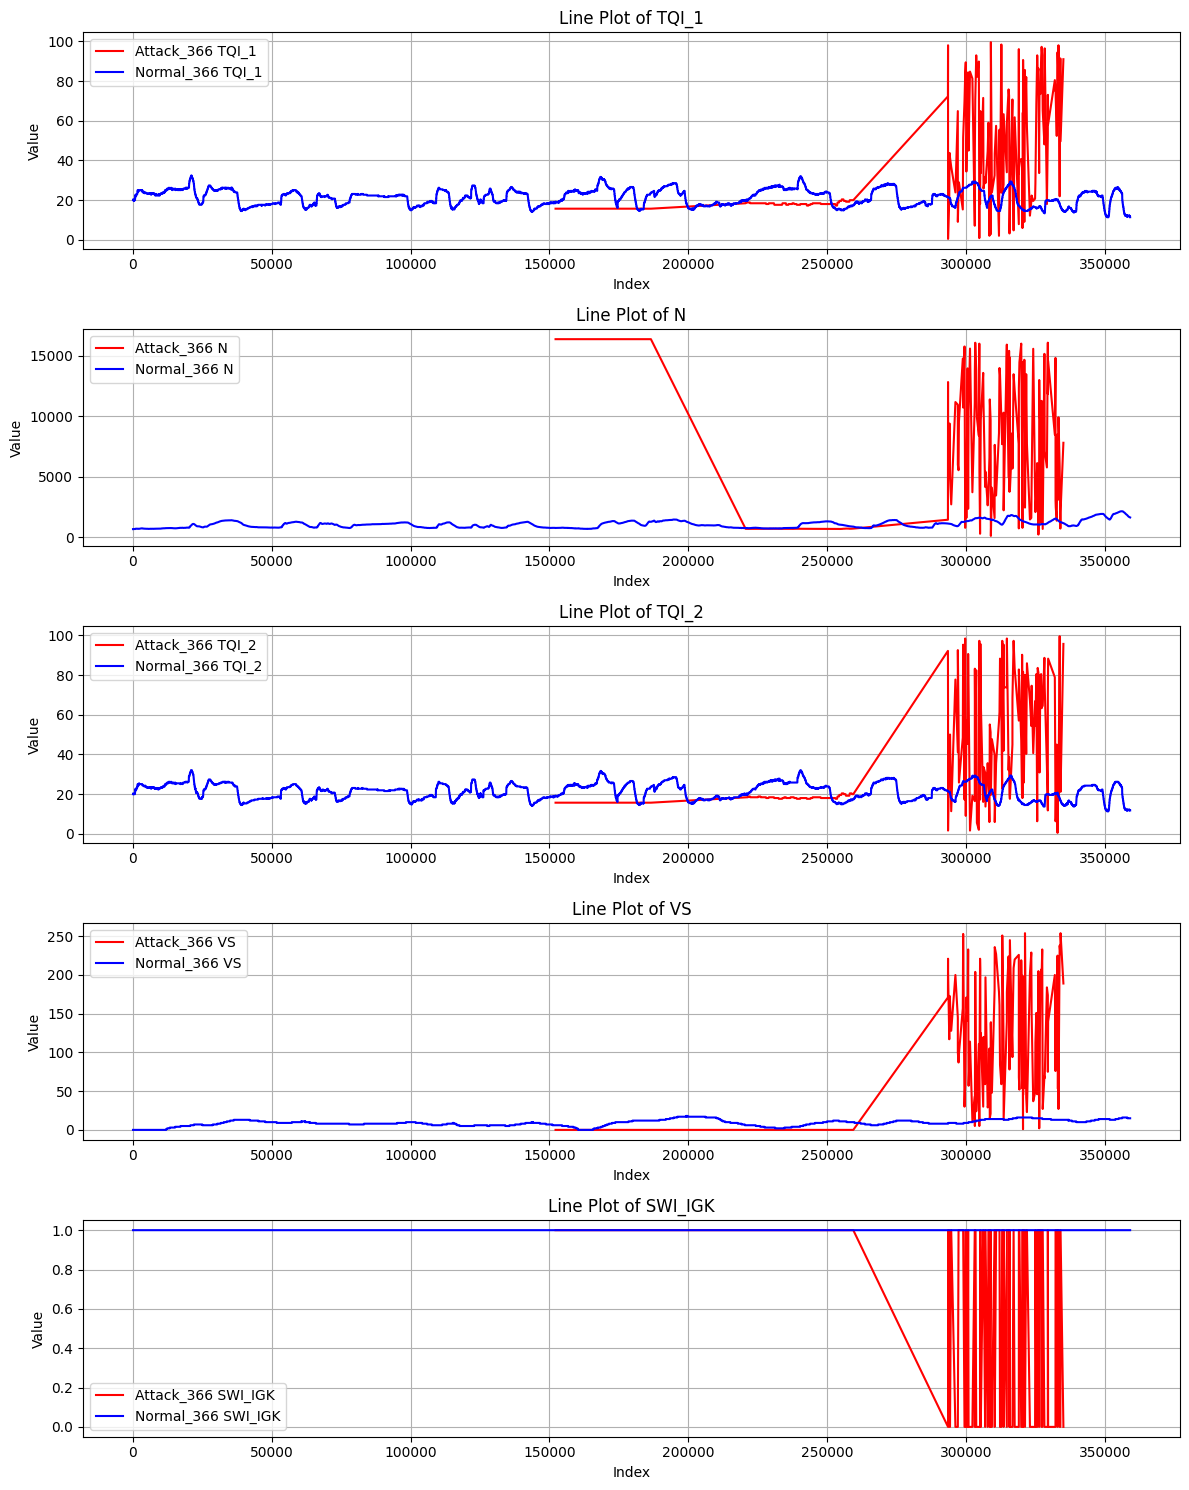

In [ ]:
columns_of_interest = ['TQI_1', 'N', 'TQI_2', 'VS', 'SWI_IGK']

plt.figure(figsize=(12, 15))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(len(columns_of_interest), 1, i)
    plt.plot(filtered_Attack_366[column], label=f'Attack_366 {column}', color='red')
    plt.plot(filtered_Normal_366[column], label=f'Normal_366 {column}', color='blue')
    plt.title(f'Line Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()